In [1]:
import torch
import wget
import os
import numpy as np
import pandas as pd

from omegaconf import OmegaConf
from pytorch_lightning import Trainer
from IPython.display import display
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from nemo.collections import nlp as nemo_nlp
from nemo.utils.exp_manager import exp_manager

[NeMo W 2022-02-25 18:32:10 experimental:27] Module <class 'nemo.collections.nlp.data.text_normalization.decoder_dataset.TextNormalizationDecoderDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-02-25 18:32:11 experimental:27] Module <class 'nemo.collections.nlp.data.text_normalization.tagger_dataset.TextNormalizationTaggerDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-02-25 18:32:11 experimental:27] Module <class 'nemo.collections.nlp.data.text_normalization.test_dataset.TextNormalizationTestDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or ru

# Convert into NeMo EL format

In [2]:
relations_train = pd.read_csv('relations_train.csv', sep='\t')
relations_train

,id,abstract_id,type,entity_1_id,entity_2_id,novel
0,0,1353340,Association,410,D007966,No
1,1,1353340,Positive_Correlation,rs74315458,D007966,Novel
2,2,1671881,Positive_Correlation,D010661,rs62514952,Novel
3,3,1671881,Positive_Correlation,D010661,rs62514953,Novel
4,4,1671881,Association,5053,D010661,No
...,...,...,...,...,...,...
4275,4275,30836660,Negative_Correlation,C009172,1278,Novel
4276,4276,30836660,Negative_Correlation,C009172,1277,Novel
4277,4277,30836660,Negative_Correlation,C009172,12825,Novel
4278,4278,30836660,Negative_Correlation,C009172,1281,Novel


In [3]:
entities_train = pd.read_csv('entities_train.csv', sep='\t')
entities_train

,id,abstract_id,offset_start,offset_finish,type,mention,entity_ids
0,0,1353340,11,39,DiseaseOrPhenotypicFeature,metachromatic leukodystrophy,D007966
1,1,1353340,111,126,GeneOrGeneProduct,arylsulfatase A,410
2,2,1353340,128,132,GeneOrGeneProduct,ARSA,410
3,3,1353340,159,187,DiseaseOrPhenotypicFeature,metachromatic leukodystrophy,D007966
4,4,1353340,189,192,DiseaseOrPhenotypicFeature,MLD,D007966
...,...,...,...,...,...,...,...
13631,13631,30836660,2237,2241,GeneOrGeneProduct,TLR4,"21898,7099"
13632,13632,30836660,2242,2251,GeneOrGeneProduct,NF-kappaB,"18033,4790"
13633,13633,30836660,2256,2260,GeneOrGeneProduct,MAPK,"26413,5594"
13634,13634,30836660,2344,2347,ChemicalEntity,Sal,C009172


In [5]:
abstract_id_list = entities_train['abstract_id'].tolist()
abstract_id_list

[1353340,
 1353340,
 1353340,
 1353340,
 1353340,
 1353340,
 1353340,
 1353340,
 1353340,
 1353340,
 1353340,
 1353340,
 1353340,
 1353340,
 1353340,
 1671881,
 1671881,
 1671881,
 1671881,
 1671881,
 1671881,
 1671881,
 1671881,
 1671881,
 1671881,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 1848636,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2422478,
 2491010,
 2491010,
 2491010,
 2491010,
 2491010,
 2491010,
 2491010,
 2491010,
 2491010,
 2491010,
 2491010,
 2491010,
 2491010,
 2491010,
 2491010,
 2491010,


In [6]:
new_id_list = []
for id in abstract_id_list:
    new_id_list.append(np.where(entities_train['abstract_id'].unique() == id)[0][0] + 1)
new_id_list

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,


In [7]:
ID_CONVERT_DIC = {abstract_id_list[i]: new_id_list[i] for i in range(len(abstract_id_list))}
ID_CONVERT_DIC

{1353340: 1,
 1671881: 2,
 1848636: 3,
 2422478: 4,
 2491010: 5,
 7468724: 6,
 7668252: 7,
 7905839: 8,
 8755918: 9,
 8829135: 10,
 9294109: 11,
 9647766: 12,
 9672936: 13,
 9746003: 14,
 10491763: 15,
 10661407: 16,
 10788334: 17,
 11009181: 18,
 11054569: 19,
 11773892: 20,
 12442272: 21,
 14722929: 22,
 15000256: 23,
 15018851: 24,
 15033202: 25,
 15042318: 26,
 15064320: 27,
 15069170: 28,
 15086325: 29,
 15111599: 30,
 15122711: 31,
 15130900: 32,
 15177686: 33,
 15184369: 34,
 15191352: 35,
 15198485: 36,
 15200408: 37,
 15233872: 38,
 15241482: 39,
 15266215: 40,
 15459183: 41,
 15459975: 42,
 15461822: 43,
 15464247: 44,
 15485686: 45,
 15523499: 46,
 15579441: 47,
 15583840: 48,
 15599941: 49,
 15602202: 50,
 15609295: 51,
 15630069: 52,
 15649253: 53,
 15668505: 54,
 15673851: 55,
 15686794: 56,
 15748645: 57,
 15749661: 58,
 15754732: 59,
 15755837: 60,
 15770495: 61,
 15807692: 62,
 15811908: 63,
 15814629: 64,
 15817013: 65,
 15820770: 66,
 15858223: 67,
 15859361: 68,
 15

## Create "Synonyms"

In [8]:
from itertools import combinations

In [9]:
tmp_entity_train = entities_train.drop_duplicates(subset='mention')
unique_entity_id_list = tmp_entity_train.entity_ids.unique()
same_entity_id_output = []
for entity_id in tqdm(unique_entity_id_list):
    tmp_mention_list = tmp_entity_train[tmp_entity_train['entity_ids'] == entity_id]['mention']
    tmp_list = list(combinations(tmp_mention_list,2))
    tmp_list = list(map(list, tmp_list))
    for i in tmp_list:
        i.insert(0, tmp_entity_train[tmp_entity_train['entity_ids'] == entity_id]['abstract_id'].iloc[0])
    same_entity_id_output += tmp_list
same_entity_id_output = pd.DataFrame.from_records(same_entity_id_output, columns=['abstract_id', 'entity_1_id', 'entity_2_id']).replace({'abstract_id': ID_CONVERT_DIC})
same_entity_id_output

100%|██████████| 2764/2764 [00:07<00:00, 392.25it/s]


,abstract_id,entity_1_id,entity_2_id
0,1,metachromatic leukodystrophy,MLD
1,1,arylsulfatase A,ARSA
2,1,arylsulfatase A,arylsulfatase
3,1,ARSA,arylsulfatase
4,1,arginine84,arginine84 to glutamine
...,...,...,...
6596,399,ARG1,Arg1
6597,399,ovalbumin,OVA
6598,400,Salidroside,Sal
6599,400,unilateral ureteric obstruction,UUO


In [11]:
train_relations_train, dev_relations_train = train_test_split(same_entity_id_output, test_size=0.2)

In [12]:
train_relations_train.to_csv('train_LitCoin_EL.tsv', index=False, header=False, sep='\t')
dev_relations_train.to_csv('dev_LitCoin_EL.tsv', index=False, header=False, sep='\t')

In [14]:
entities_train.drop_duplicates(subset='abstract_id').replace({"abstract_id": ID_CONVERT_DIC})[['abstract_id', 'mention']].to_csv('LitCoin_EL_index.tsv',
                                                                                                                                 index=False,
                                                                                                                                 header=False,
                                                                                                                                 sep='\t')

In [15]:
dev_relations_train[['abstract_id', 'entity_1_id']].to_csv('dev_LitCoin_EL_kb.tsv', index=False, header=False, sep='\t')
dev_relations_train[['abstract_id', 'entity_2_id']].to_csv('dev_LitCoin_EL_queries.tsv', index=False, header=False, sep='\t')

# Knowledge Graph Without EL

In [41]:
!pip install --upgrade networkx

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 1.9 MB 25.3 MB/s eta 0:00:01
  Attempting uninstall: networkx
    Found existing installation: networkx 2.0
    Uninstalling networkx-2.0:
      Successfully uninstalled networkx-2.0


In [2]:
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
print(nx.__version__)

2.6.3


In [8]:
tmp_dict = entities_train.drop_duplicates(subset='entity_ids', keep='first')[['entity_ids', 'mention']].set_index('entity_ids').T.to_dict('records')[0]

In [9]:
tmp_df = relations_train.replace({"entity_1_id": tmp_dict, "entity_2_id":tmp_dict}).rename(columns={"type":"edge"})[['entity_1_id', 'entity_2_id', 'edge']]

In [15]:
G=nx.from_pandas_edgelist(tmp_df[tmp_df['edge']=="Cotreatment"], "entity_1_id", "entity_2_id", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

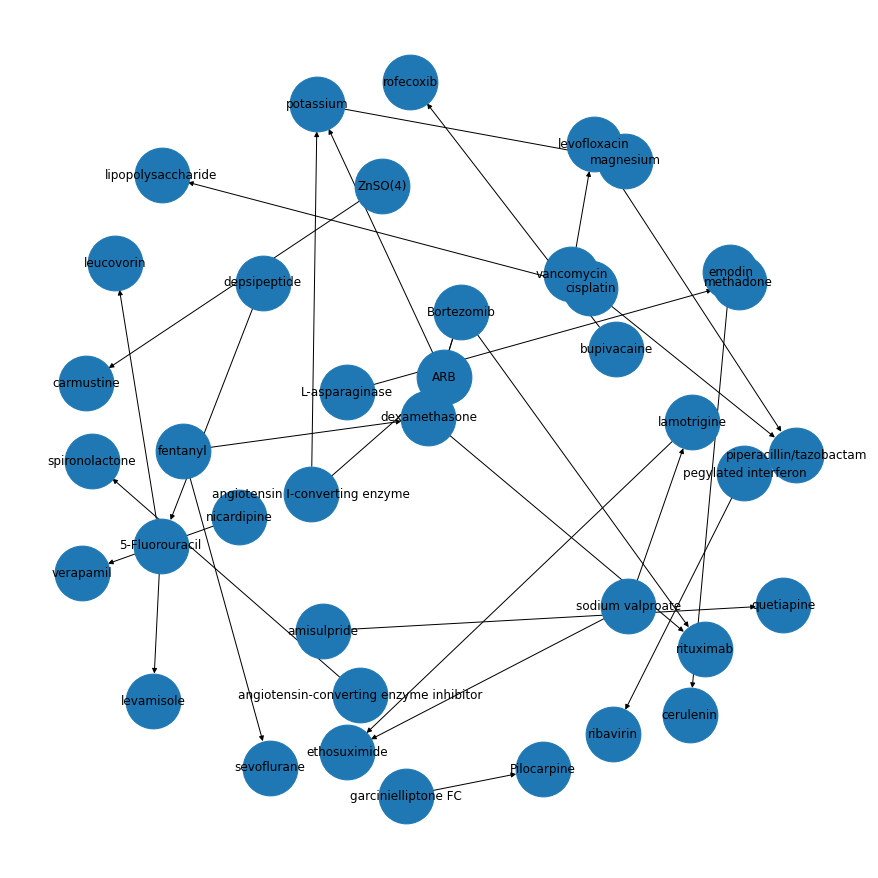

In [20]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 1)
nx.draw(G, with_labels=True, node_size=3000, pos = pos)
plt.show()

# EL

In [16]:
PROJECT_DIR = "."
DATA_DIR = os.path.join(PROJECT_DIR, "LitCoin_EL")

In [21]:
!unzip {PROJECT_DIR}/LitCoin_EL.zip -d {PROJECT_DIR}

Archive:  ./LitCoin_EL.zip
   creating: ./LitCoin_EL/
  inflating: ./LitCoin_EL/dev_LitCoin_EL.tsv  
  inflating: ./LitCoin_EL/dev_LitCoin_EL_kb.tsv  
  inflating: ./LitCoin_EL/dev_LitCoin_EL_queries.tsv  
  inflating: ./LitCoin_EL/LitCoin_EL_index.tsv  
  inflating: ./LitCoin_EL/train_LitCoin_EL.tsv  


In [18]:
# Download config
wget.download("https://raw.githubusercontent.com/vadam5/NeMo/main/examples/nlp/entity_linking/conf/tiny_example_entity_linking_config.yaml",
              os.path.join(PROJECT_DIR, "tiny_example_entity_linking_config.yaml"))

# Load in config file
cfg = OmegaConf.load(os.path.join(PROJECT_DIR, "tiny_example_entity_linking_config.yaml"))

# Set config file variables
cfg.project_dir = PROJECT_DIR
cfg.model.nemo_path = os.path.join(PROJECT_DIR, "tiny_example_sap_bert_model.nemo")
cfg.model.train_ds.data_file = os.path.join(DATA_DIR, "train_LitCoin_EL.tsv")
cfg.model.train_ds.batch_size = 512
cfg.model.validation_ds.data_file = os.path.join(DATA_DIR, "dev_LitCoin_EL.tsv")
cfg.model.validation_ds.batch_size = 512
cfg.index.index_save_name = "LitCoin_EL_index"
cfg.trainer.max_epochs = 10
cfg.index.index_ds.data_file = os.path.join(DATA_DIR, "LitCoin_EL_index.tsv")

# remove distributed training flags
cfg.trainer.accelerator = None

In [19]:
print(OmegaConf.to_yaml(cfg))

project_dir: .
name: SelfAlignmentPretrainingForMedicalEntityLinking
trainer:
  gpus: 1
  num_nodes: 1
  max_epochs: 10
  max_steps: null
  accumulate_grad_batches: 1
  precision: 16
  accelerator: null
  gradient_clip_val: 0.0
  log_every_n_steps: 1
  val_check_interval: 2
  checkpoint_callback: false
  logger: false
model:
  nemo_path: ./tiny_example_sap_bert_model.nemo
  max_seq_length: 128
  language_model:
    pretrained_model_name: bert-base-uncased
    config_file: null
    config: null
    lm_checkpoint: null
  tokenizer:
    tokenizer_name: ${model.language_model.pretrained_model_name}
    vocab_file: null
    tokenizer_model: null
    do_lower_case: true
  loss_params: null
  train_ds:
    data_file: ./LitCoin_EL/train_LitCoin_EL.tsv
    max_seq_length: ${model.max_seq_length}
    batch_size: 512
    shuffle: true
    num_workers: 2
    pin_memory: false
    drop_last: false
  validation_ds:
    data_file: ./LitCoin_EL/dev_LitCoin_EL.tsv
    max_seq_length: ${model.max_seq_le

In [22]:
# Initialize the trainer and model
trainer = Trainer(**cfg.trainer)
exp_manager(trainer, cfg.get("exp_manager", None))
model = nemo_nlp.models.EntityLinkingModel(cfg=cfg.model, trainer=trainer)

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


[NeMo I 2022-02-25 19:32:16 exp_manager:220] Experiments will be logged at SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43
[NeMo I 2022-02-25 19:32:16 exp_manager:569] TensorboardLogger has been set up


[NeMo W 2022-02-25 19:32:16 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:240: LightningDeprecationWarning: `ModelCheckpoint(every_n_val_epochs)` is deprecated in v1.4 and will be removed in v1.6. Please use `every_n_epochs` instead.
      rank_zero_deprecation(
    


[NeMo I 2022-02-25 19:32:19 entity_linking_dataset:61] Getting datafile newline indices
[NeMo I 2022-02-25 19:32:19 entity_linking_dataset:78] Loaded dataset with 5280 examples
[NeMo I 2022-02-25 19:32:19 entity_linking_dataset:61] Getting datafile newline indices
[NeMo I 2022-02-25 19:32:19 entity_linking_dataset:78] Loaded dataset with 1321 examples


I0225 19:32:19.775650 140083266586432 filelock.py:274] Lock 140077067066144 acquired on /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f.lock


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

I0225 19:32:31.024012 140083266586432 filelock.py:318] Lock 140077067066144 released on /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f.lock
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly i

In [23]:
# Train and save the model
trainer.fit(model)
model.save_to(cfg.model.nemo_path)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2022-02-25 19:32:40 modelPT:544] Optimizer config = Adam (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        eps: 1e-08
        lr: 3e-05
        weight_decay: 0.0
    )
[NeMo I 2022-02-25 19:32:40 lr_scheduler:621] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7f6627b89eb0>" 
    will be used during training (effective maximum steps = 110) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: 0.1
    min_lr: 0.0
    last_epoch: -1
    max_steps: 110
    )



  | Name  | Type                | Params
----------------------------------------------
0 | model | BertEncoder         | 109 M 
1 | loss  | MultiSimilarityLoss | 0     
----------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.929   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 19:32:40 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    
[NeMo W 2022-02-25 19:32:40 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 19:32:40 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 19:33:16 entity_linking_model:125] val loss: 1.840698480606079
[NeMo I 2022-02-25 19:33:50 entity_linking_model:125] val loss: 1.865105390548706


[NeMo W 2022-02-25 19:33:50 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    


Training: -1it [00:00, ?it/s]

[NeMo W 2022-02-25 19:33:50 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 19:33:50 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 19:35:02 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 19:35:02 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 19:35:36 entity_linking_model:125] val loss: 1.8319077491760254
[NeMo I 2022-02-25 19:36:09 entity_linking_model:125] val loss: 1.8552215099334717
[NeMo I 2022-02-25 19:36:20 entity_linking_model:125] val loss: 1.605093002319336


Epoch 0, global step 1: val_loss reached 1.76407 (best 1.76407), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=1.7641-epoch=0.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 19:37:48 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 19:37:48 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 19:38:21 entity_linking_model:125] val loss: 1.821479320526123
[NeMo I 2022-02-25 19:38:54 entity_linking_model:125] val loss: 1.84531831741333
[NeMo I 2022-02-25 19:39:05 entity_linking_model:125] val loss: 1.5939041376113892


Epoch 0, global step 3: val_loss reached 1.75357 (best 1.75357), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=1.7536-epoch=0.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 19:40:38 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 19:40:38 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 19:41:12 entity_linking_model:125] val loss: 1.8146740198135376
[NeMo I 2022-02-25 19:41:44 entity_linking_model:125] val loss: 1.8413903713226318
[NeMo I 2022-02-25 19:41:55 entity_linking_model:125] val loss: 1.585431456565857


Epoch 0, global step 5: val_loss reached 1.74717 (best 1.74717), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=1.7472-epoch=0.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 19:43:25 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 19:43:25 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 19:43:59 entity_linking_model:125] val loss: 1.7954182624816895
[NeMo I 2022-02-25 19:44:33 entity_linking_model:125] val loss: 1.824634313583374
[NeMo I 2022-02-25 19:44:43 entity_linking_model:125] val loss: 1.56770920753479


Epoch 0, global step 7: val_loss reached 1.72925 (best 1.72925), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=1.7293-epoch=0.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 19:46:13 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 19:46:13 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 19:46:47 entity_linking_model:125] val loss: 1.7800942659378052
[NeMo I 2022-02-25 19:47:19 entity_linking_model:125] val loss: 1.8085803985595703
[NeMo I 2022-02-25 19:47:31 entity_linking_model:125] val loss: 1.55316960811615


Epoch 0, global step 9: val_loss reached 1.71395 (best 1.71395), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=1.7139-epoch=0.ckpt" as top 3
[NeMo W 2022-02-25 19:47:52 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 19:47:52 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 19:49:03 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 19:49:03 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 19:49:36 entity_linking_model:125] val loss: 1.7408602237701416
[NeMo I 2022-02-25 19:50:08 entity_linking_model:125] val loss: 1.768174171447754
[NeMo I 2022-02-25 19:50:19 entity_linking_model:125] val loss: 1.5033369064331055


Epoch 1, global step 12: val_loss reached 1.67079 (best 1.67079), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=1.6708-epoch=1.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 19:51:46 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 19:51:46 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 19:52:19 entity_linking_model:125] val loss: 1.711686372756958
[NeMo I 2022-02-25 19:52:53 entity_linking_model:125] val loss: 1.7375411987304688
[NeMo I 2022-02-25 19:53:03 entity_linking_model:125] val loss: 1.472193956375122


Epoch 1, global step 14: val_loss reached 1.64047 (best 1.64047), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=1.6405-epoch=1.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 19:54:31 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 19:54:31 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 19:55:03 entity_linking_model:125] val loss: 1.6873360872268677
[NeMo I 2022-02-25 19:55:38 entity_linking_model:125] val loss: 1.7160195112228394
[NeMo I 2022-02-25 19:55:49 entity_linking_model:125] val loss: 1.4448621273040771


Epoch 1, global step 16: val_loss reached 1.61607 (best 1.61607), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=1.6161-epoch=1.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 19:57:17 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 19:57:17 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 19:57:50 entity_linking_model:125] val loss: 1.6626352071762085
[NeMo I 2022-02-25 19:58:23 entity_linking_model:125] val loss: 1.6913352012634277
[NeMo I 2022-02-25 19:58:34 entity_linking_model:125] val loss: 1.4214035272598267


Epoch 1, global step 18: val_loss reached 1.59179 (best 1.59179), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=1.5918-epoch=1.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:00:03 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:00:03 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:00:36 entity_linking_model:125] val loss: 1.6385817527770996
[NeMo I 2022-02-25 20:01:08 entity_linking_model:125] val loss: 1.6679012775421143
[NeMo I 2022-02-25 20:01:19 entity_linking_model:125] val loss: 1.3906419277191162


Epoch 1, global step 20: val_loss reached 1.56571 (best 1.56571), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=1.5657-epoch=1.ckpt" as top 3
[NeMo W 2022-02-25 20:01:40 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:01:40 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:02:50 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:02:50 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:03:22 entity_linking_model:125] val loss: 1.5877649784088135
[NeMo I 2022-02-25 20:03:55 entity_linking_model:125] val loss: 1.6433403491973877
[NeMo I 2022-02-25 20:04:06 entity_linking_model:125] val loss: 1.3300046920776367


Epoch 2, global step 23: val_loss reached 1.52037 (best 1.52037), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=1.5204-epoch=2.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:05:32 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:05:32 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:06:05 entity_linking_model:125] val loss: 1.5194482803344727
[NeMo I 2022-02-25 20:06:38 entity_linking_model:125] val loss: 1.596502423286438
[NeMo I 2022-02-25 20:06:50 entity_linking_model:125] val loss: 1.2173306941986084


Epoch 2, global step 25: val_loss reached 1.44443 (best 1.44443), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=1.4444-epoch=2.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:08:19 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:08:19 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:08:51 entity_linking_model:125] val loss: 1.447335958480835
[NeMo I 2022-02-25 20:09:24 entity_linking_model:125] val loss: 1.516316533088684
[NeMo I 2022-02-25 20:09:35 entity_linking_model:125] val loss: 1.026777744293213


Epoch 2, global step 27: val_loss reached 1.33014 (best 1.33014), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=1.3301-epoch=2.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:11:00 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:11:00 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:11:34 entity_linking_model:125] val loss: 1.3233261108398438
[NeMo I 2022-02-25 20:12:06 entity_linking_model:125] val loss: 1.2755415439605713
[NeMo I 2022-02-25 20:12:17 entity_linking_model:125] val loss: 0.9410070180892944


Epoch 2, global step 29: val_loss reached 1.17996 (best 1.17996), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=1.1800-epoch=2.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:13:45 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:13:45 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:14:18 entity_linking_model:125] val loss: 1.2268316745758057
[NeMo I 2022-02-25 20:14:50 entity_linking_model:125] val loss: 1.1439813375473022
[NeMo I 2022-02-25 20:15:01 entity_linking_model:125] val loss: 0.8715524077415466


Epoch 2, global step 31: val_loss reached 1.08079 (best 1.08079), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=1.0808-epoch=2.ckpt" as top 3
[NeMo W 2022-02-25 20:15:23 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:15:23 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:16:44 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:16:44 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:17:28 entity_linking_model:125] val loss: 0.7777178287506104
[NeMo I 2022-02-25 20:18:10 entity_linking_model:125] val loss: 0.8493684530258179
[NeMo I 2022-02-25 20:18:22 entity_linking_model:125] val loss: 0.7405886650085449


Epoch 3, global step 34: val_loss reached 0.78922 (best 0.78922), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.7892-epoch=3.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:19:48 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:19:48 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:20:21 entity_linking_model:125] val loss: 0.7758229970932007
[NeMo I 2022-02-25 20:20:54 entity_linking_model:125] val loss: 0.8425506353378296
[NeMo I 2022-02-25 20:21:06 entity_linking_model:125] val loss: 0.7307775020599365


Epoch 3, global step 36: val_loss reached 0.78305 (best 0.78305), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.7831-epoch=3.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:22:32 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:22:32 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:23:06 entity_linking_model:125] val loss: 0.7712271213531494
[NeMo I 2022-02-25 20:23:38 entity_linking_model:125] val loss: 0.8352721929550171
[NeMo I 2022-02-25 20:23:49 entity_linking_model:125] val loss: 0.7235934138298035


Epoch 3, global step 38: val_loss reached 0.77670 (best 0.77670), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.7767-epoch=3.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:25:18 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:25:18 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:25:50 entity_linking_model:125] val loss: 0.7618939876556396
[NeMo I 2022-02-25 20:26:24 entity_linking_model:125] val loss: 0.8185881972312927
[NeMo I 2022-02-25 20:26:35 entity_linking_model:125] val loss: 0.7047366499900818


Epoch 3, global step 40: val_loss reached 0.76174 (best 0.76174), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.7617-epoch=3.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:28:03 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:28:03 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:28:36 entity_linking_model:125] val loss: 0.7567579746246338
[NeMo I 2022-02-25 20:29:09 entity_linking_model:125] val loss: 0.7985554933547974
[NeMo I 2022-02-25 20:29:19 entity_linking_model:125] val loss: 0.6960009932518005


Epoch 3, global step 42: val_loss reached 0.75044 (best 0.75044), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.7504-epoch=3.ckpt" as top 3
[NeMo W 2022-02-25 20:29:42 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:29:42 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:30:52 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:30:52 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:31:25 entity_linking_model:125] val loss: 0.7366276979446411
[NeMo I 2022-02-25 20:31:57 entity_linking_model:125] val loss: 0.7491946220397949
[NeMo I 2022-02-25 20:32:08 entity_linking_model:125] val loss: 0.6884382367134094


Epoch 4, global step 45: val_loss reached 0.72475 (best 0.72475), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.7248-epoch=4.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:33:35 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:33:35 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:34:08 entity_linking_model:125] val loss: 0.7246503829956055
[NeMo I 2022-02-25 20:34:42 entity_linking_model:125] val loss: 0.7410727739334106
[NeMo I 2022-02-25 20:34:54 entity_linking_model:125] val loss: 0.6795262694358826


Epoch 4, global step 47: val_loss reached 0.71508 (best 0.71508), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.7151-epoch=4.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:36:32 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:36:32 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:37:07 entity_linking_model:125] val loss: 0.7187590599060059
[NeMo I 2022-02-25 20:37:40 entity_linking_model:125] val loss: 0.7316598892211914
[NeMo I 2022-02-25 20:37:50 entity_linking_model:125] val loss: 0.6733763813972473


Epoch 4, global step 49: val_loss reached 0.70793 (best 0.70793), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.7079-epoch=4.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:39:20 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:39:20 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:39:53 entity_linking_model:125] val loss: 0.7128342390060425
[NeMo I 2022-02-25 20:40:26 entity_linking_model:125] val loss: 0.7318273186683655
[NeMo I 2022-02-25 20:40:37 entity_linking_model:125] val loss: 0.6681264638900757


Epoch 4, global step 51: val_loss reached 0.70426 (best 0.70426), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.7043-epoch=4.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:42:05 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:42:05 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:42:38 entity_linking_model:125] val loss: 0.7047312259674072
[NeMo I 2022-02-25 20:43:11 entity_linking_model:125] val loss: 0.7302160263061523
[NeMo I 2022-02-25 20:43:22 entity_linking_model:125] val loss: 0.6629112958908081


Epoch 4, global step 53: val_loss reached 0.69929 (best 0.69929), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6993-epoch=4.ckpt" as top 3
[NeMo W 2022-02-25 20:43:42 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:43:42 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:44:51 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:44:51 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:45:24 entity_linking_model:125] val loss: 0.7000749111175537
[NeMo I 2022-02-25 20:45:57 entity_linking_model:125] val loss: 0.7265698909759521
[NeMo I 2022-02-25 20:46:08 entity_linking_model:125] val loss: 0.6605983972549438


Epoch 5, global step 56: val_loss reached 0.69575 (best 0.69575), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6957-epoch=5.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:47:34 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:47:34 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:48:07 entity_linking_model:125] val loss: 0.6993483901023865
[NeMo I 2022-02-25 20:48:40 entity_linking_model:125] val loss: 0.7223725318908691
[NeMo I 2022-02-25 20:48:51 entity_linking_model:125] val loss: 0.6569428443908691


Epoch 5, global step 58: val_loss reached 0.69289 (best 0.69289), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6929-epoch=5.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:50:18 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:50:18 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:50:51 entity_linking_model:125] val loss: 0.6962165832519531
[NeMo I 2022-02-25 20:51:23 entity_linking_model:125] val loss: 0.7206908464431763
[NeMo I 2022-02-25 20:51:34 entity_linking_model:125] val loss: 0.6503627896308899


Epoch 5, global step 60: val_loss reached 0.68909 (best 0.68909), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6891-epoch=5.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:53:00 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:53:00 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:53:32 entity_linking_model:125] val loss: 0.6925555467605591
[NeMo I 2022-02-25 20:54:06 entity_linking_model:125] val loss: 0.718092679977417
[NeMo I 2022-02-25 20:54:17 entity_linking_model:125] val loss: 0.6446784734725952


Epoch 5, global step 62: val_loss reached 0.68511 (best 0.68511), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6851-epoch=5.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:55:56 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:55:56 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:56:28 entity_linking_model:125] val loss: 0.6860004663467407
[NeMo I 2022-02-25 20:57:01 entity_linking_model:125] val loss: 0.7164342999458313
[NeMo I 2022-02-25 20:57:12 entity_linking_model:125] val loss: 0.6405414342880249


Epoch 5, global step 64: val_loss reached 0.68099 (best 0.68099), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6810-epoch=5.ckpt" as top 3
[NeMo W 2022-02-25 20:57:33 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:57:33 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 20:58:42 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 20:58:42 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 20:59:16 entity_linking_model:125] val loss: 0.6814317107200623
[NeMo I 2022-02-25 20:59:49 entity_linking_model:125] val loss: 0.7167834639549255
[NeMo I 2022-02-25 21:00:02 entity_linking_model:125] val loss: 0.6369282603263855


Epoch 6, global step 67: val_loss reached 0.67838 (best 0.67838), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6784-epoch=6.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 21:01:30 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:01:30 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 21:02:02 entity_linking_model:125] val loss: 0.6762551069259644
[NeMo I 2022-02-25 21:02:34 entity_linking_model:125] val loss: 0.7170356512069702
[NeMo I 2022-02-25 21:02:45 entity_linking_model:125] val loss: 0.6349092721939087


Epoch 6, global step 69: val_loss reached 0.67607 (best 0.67607), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6761-epoch=6.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 21:04:09 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:04:09 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 21:04:42 entity_linking_model:125] val loss: 0.6719609498977661
[NeMo I 2022-02-25 21:05:21 entity_linking_model:125] val loss: 0.7165409326553345
[NeMo I 2022-02-25 21:05:32 entity_linking_model:125] val loss: 0.6331484317779541


Epoch 6, global step 71: val_loss reached 0.67388 (best 0.67388), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6739-epoch=6.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 21:06:59 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:06:59 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 21:07:32 entity_linking_model:125] val loss: 0.6682966947555542
[NeMo I 2022-02-25 21:08:05 entity_linking_model:125] val loss: 0.7159816026687622
[NeMo I 2022-02-25 21:08:15 entity_linking_model:125] val loss: 0.6308950185775757


Epoch 6, global step 73: val_loss reached 0.67172 (best 0.67172), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6717-epoch=6.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 21:09:51 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:09:51 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 21:10:26 entity_linking_model:125] val loss: 0.6655572652816772
[NeMo I 2022-02-25 21:11:00 entity_linking_model:125] val loss: 0.7153285145759583
[NeMo I 2022-02-25 21:11:11 entity_linking_model:125] val loss: 0.6297770738601685


Epoch 6, global step 75: val_loss reached 0.67022 (best 0.67022), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6702-epoch=6.ckpt" as top 3
[NeMo W 2022-02-25 21:11:33 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:11:33 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 21:12:41 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:12:41 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 21:13:14 entity_linking_model:125] val loss: 0.6608215570449829
[NeMo I 2022-02-25 21:13:48 entity_linking_model:125] val loss: 0.714085578918457
[NeMo I 2022-02-25 21:13:58 entity_linking_model:125] val loss: 0.628585934638977


Epoch 7, global step 78: val_loss reached 0.66783 (best 0.66783), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6678-epoch=7.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 21:15:22 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:15:22 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 21:15:54 entity_linking_model:125] val loss: 0.6589417457580566
[NeMo I 2022-02-25 21:16:26 entity_linking_model:125] val loss: 0.7141445875167847
[NeMo I 2022-02-25 21:16:36 entity_linking_model:125] val loss: 0.6273510456085205


Epoch 7, global step 80: val_loss reached 0.66681 (best 0.66681), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6668-epoch=7.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 21:18:00 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:18:00 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 21:18:40 entity_linking_model:125] val loss: 0.6577411890029907
[NeMo I 2022-02-25 21:19:16 entity_linking_model:125] val loss: 0.713411808013916
[NeMo I 2022-02-25 21:19:27 entity_linking_model:125] val loss: 0.6263411045074463


Epoch 7, global step 82: val_loss reached 0.66583 (best 0.66583), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6658-epoch=7.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 21:20:51 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:20:51 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 21:21:23 entity_linking_model:125] val loss: 0.6551242470741272
[NeMo I 2022-02-25 21:21:54 entity_linking_model:125] val loss: 0.7131860256195068
[NeMo I 2022-02-25 21:22:05 entity_linking_model:125] val loss: 0.6254348754882812


Epoch 7, global step 84: val_loss reached 0.66458 (best 0.66458), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6646-epoch=7.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 21:23:29 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:23:29 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 21:24:01 entity_linking_model:125] val loss: 0.6544063091278076
[NeMo I 2022-02-25 21:24:33 entity_linking_model:125] val loss: 0.7125506401062012
[NeMo I 2022-02-25 21:24:44 entity_linking_model:125] val loss: 0.6251708269119263


Epoch 7, global step 86: val_loss reached 0.66404 (best 0.66404), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6640-epoch=7.ckpt" as top 3
[NeMo W 2022-02-25 21:25:06 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:25:06 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 21:26:15 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:26:15 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 21:26:48 entity_linking_model:125] val loss: 0.6544950008392334
[NeMo I 2022-02-25 21:27:20 entity_linking_model:125] val loss: 0.7125311493873596
[NeMo I 2022-02-25 21:27:31 entity_linking_model:125] val loss: 0.6246498823165894


Epoch 8, global step 89: val_loss reached 0.66389 (best 0.66389), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6639-epoch=8.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 21:28:55 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:28:55 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 21:29:26 entity_linking_model:125] val loss: 0.654237687587738
[NeMo I 2022-02-25 21:29:58 entity_linking_model:125] val loss: 0.712232768535614
[NeMo I 2022-02-25 21:30:09 entity_linking_model:125] val loss: 0.624028742313385


Epoch 8, global step 91: val_loss reached 0.66350 (best 0.66350), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6635-epoch=8.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 21:31:50 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:31:50 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 21:32:22 entity_linking_model:125] val loss: 0.6542669534683228
[NeMo I 2022-02-25 21:32:53 entity_linking_model:125] val loss: 0.7117935419082642
[NeMo I 2022-02-25 21:33:04 entity_linking_model:125] val loss: 0.6237586140632629


Epoch 8, global step 93: val_loss reached 0.66327 (best 0.66327), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6633-epoch=8.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 21:34:29 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:34:29 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 21:35:01 entity_linking_model:125] val loss: 0.6541373133659363
[NeMo I 2022-02-25 21:35:33 entity_linking_model:125] val loss: 0.711772084236145
[NeMo I 2022-02-25 21:35:44 entity_linking_model:125] val loss: 0.6235790252685547


Epoch 8, global step 95: val_loss reached 0.66316 (best 0.66316), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6632-epoch=8.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 21:37:10 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:37:10 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 21:37:42 entity_linking_model:125] val loss: 0.6539157629013062
[NeMo I 2022-02-25 21:38:15 entity_linking_model:125] val loss: 0.7116947770118713
[NeMo I 2022-02-25 21:38:25 entity_linking_model:125] val loss: 0.6234509944915771


Epoch 8, global step 97: val_loss reached 0.66302 (best 0.66302), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6630-epoch=8.ckpt" as top 3
[NeMo W 2022-02-25 21:38:50 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:38:50 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 21:39:59 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:39:59 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 21:40:31 entity_linking_model:125] val loss: 0.6538018584251404
[NeMo I 2022-02-25 21:41:03 entity_linking_model:125] val loss: 0.7117956280708313
[NeMo I 2022-02-25 21:41:13 entity_linking_model:125] val loss: 0.6233236193656921


Epoch 9, global step 100: val_loss reached 0.66297 (best 0.66297), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6630-epoch=9.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 21:42:35 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:42:35 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 21:43:06 entity_linking_model:125] val loss: 0.6536886096000671
[NeMo I 2022-02-25 21:43:37 entity_linking_model:125] val loss: 0.7118511199951172
[NeMo I 2022-02-25 21:43:47 entity_linking_model:125] val loss: 0.6232900023460388


Epoch 9, global step 102: val_loss reached 0.66294 (best 0.66294), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6629-epoch=9.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 21:45:12 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:45:12 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 21:45:43 entity_linking_model:125] val loss: 0.6536937952041626
[NeMo I 2022-02-25 21:46:14 entity_linking_model:125] val loss: 0.7117501497268677
[NeMo I 2022-02-25 21:46:25 entity_linking_model:125] val loss: 0.6232460737228394


Epoch 9, global step 104: val_loss reached 0.66290 (best 0.66290), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6629-epoch=9-v1.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 21:47:48 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:47:48 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 21:48:31 entity_linking_model:125] val loss: 0.6536586880683899
[NeMo I 2022-02-25 21:49:05 entity_linking_model:125] val loss: 0.711737871170044
[NeMo I 2022-02-25 21:49:16 entity_linking_model:125] val loss: 0.6232398152351379


Epoch 9, global step 106: val_loss reached 0.66288 (best 0.66288), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6629-epoch=9-v2.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-02-25 21:50:40 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 21:50:40 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    


[NeMo I 2022-02-25 21:51:12 entity_linking_model:125] val loss: 0.6523348093032837
[NeMo I 2022-02-25 21:51:42 entity_linking_model:125] val loss: 0.7117273807525635
[NeMo I 2022-02-25 21:51:53 entity_linking_model:125] val loss: 0.6232248544692993


Epoch 9, global step 108: val_loss reached 0.66243 (best 0.66243), saving model to "/workspace/nemo/SelfAlignmentPretrainingTinyExample/2022-02-25_19-31-43/checkpoints/SelfAlignmentPretrainingTinyExample--val_loss=0.6624-epoch=9.ckpt" as top 3


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Restore second stage pretrained model
sap_model_cfg = cfg
sap_model_cfg.index.index_save_name = os.path.join(PROJECT_DIR, "LitCoin_EL_index")
sap_model_cfg.index.index_ds.data_file = os.path.join(DATA_DIR, "LitCoin_EL_index.tsv")
sap_model = nemo_nlp.models.EntityLinkingModel.restore_from(sap_model_cfg.model.nemo_path).to(device)

# Load original model
base_model_cfg = OmegaConf.load(os.path.join(PROJECT_DIR, "tiny_example_entity_linking_config.yaml"))

# Set train/val datasets to None to avoid loading datasets associated with training
base_model_cfg.model.train_ds = None
base_model_cfg.model.validation_ds = None
base_model_cfg.index.index_save_name = os.path.join(PROJECT_DIR, "base_model_index")
base_model_cfg.index.index_ds.data_file = os.path.join(DATA_DIR, "LitCoin_EL_index.tsv")
base_model = nemo_nlp.models.EntityLinkingModel(base_model_cfg.model).to(device)

[NeMo W 2022-02-25 22:11:28 modelPT:130] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    data_file: ./LitCoin_EL/train_LitCoin_EL.tsv
    max_seq_length: 128
    batch_size: 512
    shuffle: true
    num_workers: 2
    pin_memory: false
    drop_last: false
    
[NeMo W 2022-02-25 22:11:28 modelPT:137] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    data_file: ./LitCoin_EL/dev_LitCoin_EL.tsv
    max_seq_length: 128
    batch_size: 512
    shuffle: false
    num_workers: 2
    pin_memory: false
    drop_last: false
    
[NeMo W 2022-02-25 22:11:28 modelPT:1062] World size can only be set by PyTorch Lightning Trainer.
Some weights of the model checkpoint at

[NeMo I 2022-02-25 22:11:33 save_restore_connector:143] Model EntityLinkingModel was successfully restored from /workspace/nemo/tiny_example_sap_bert_model.nemo.


[NeMo W 2022-02-25 22:11:36 modelPT:1062] World size can only be set by PyTorch Lightning Trainer.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncase

In [25]:
# Helper function to get data embeddings
def get_embeddings(model, dataloader):
    embeddings, cids = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids, token_type_ids, attention_mask, batch_cids = batch
            batch_embeddings = model.forward(input_ids=input_ids.to(device), 
                                             token_type_ids=token_type_ids.to(device), 
                                             attention_mask=attention_mask.to(device))

            # Accumulate index embeddings and their corresponding IDs
            embeddings.extend(batch_embeddings.cpu().detach().numpy())
            cids.extend(batch_cids)
            
    return embeddings, cids

In [26]:
def evaluate(model, test_kb, test_queries, ks):
    # Initialize knowledge base and query data loaders
    test_kb_dataloader = model.setup_dataloader(test_kb, is_index_data=True)
    test_query_dataloader = model.setup_dataloader(test_queries, is_index_data=True)
    
    # Get knowledge base and query embeddings
    test_kb_embs, test_kb_cids = get_embeddings(model, test_kb_dataloader)
    test_query_embs, test_query_cids = get_embeddings(model, test_query_dataloader)

    # Calculate the cosine distance between each query and knowledge base concept
    score_matrix = np.matmul(np.array(test_query_embs), np.array(test_kb_embs).T)
    accs = {k : 0 for k in ks}
    
    # Compare the knowledge base IDs of the knowledge base entities with 
    # the smallest cosine distance from the query 
    for query_idx in tqdm(range(len(test_query_cids))):
        query_emb = test_query_embs[query_idx]
        query_cid = test_query_cids[query_idx]
        query_scores = score_matrix[query_idx]

        for k in ks:
            topk_idxs = np.argpartition(query_scores, -k)[-k:]
            topk_cids = [test_kb_cids[idx] for idx in topk_idxs]
            
            # If the correct query ID is amoung the top k closest kb IDs
            # the model correctly linked the entity
            match = int(query_cid in topk_cids)
            accs[k] += match

    for k in ks:
        accs[k] /= len(test_query_cids)
                
    return accs

In [27]:
# Create configs for our test data
test_kb = OmegaConf.create({
    "data_file": os.path.join(DATA_DIR, "dev_LitCoin_EL_kb.tsv"),
    "max_seq_length": 128,
    "batch_size": 10,
    "shuffle": False,
})

test_queries = OmegaConf.create({
    "data_file": os.path.join(DATA_DIR, "dev_LitCoin_EL_queries.tsv"),
    "max_seq_length": 128,
    "batch_size": 10,
    "shuffle": False,
})

ks = [1, 5]

# Evaluate both models on our test data
base_accs = evaluate(base_model, test_kb, test_queries, ks)
base_accs["Model"] = "BERT Base Baseline"

sap_accs = evaluate(sap_model, test_kb, test_queries, ks)
sap_accs["Model"] = "BERT + SAP"

print("Top 1 and Top 5 Accuracy Comparison:")
results_df = pd.DataFrame([base_accs, sap_accs], columns=["Model", 1, 5])
results_df = results_df.style.set_properties(**{'text-align': 'left', }).set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
display(results_df)

[NeMo I 2022-02-25 22:11:41 entity_linking_dataset:61] Getting datafile newline indices
[NeMo I 2022-02-25 22:11:41 entity_linking_dataset:78] Loaded dataset with 1321 examples
[NeMo I 2022-02-25 22:11:41 entity_linking_dataset:61] Getting datafile newline indices
[NeMo I 2022-02-25 22:11:41 entity_linking_dataset:78] Loaded dataset with 1321 examples


  0%|          | 0/133 [00:00<?, ?it/s][NeMo W 2022-02-25 22:11:41 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 22:11:41 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
  0%|          | 0/133 [00:00<?, ?it/s][NeMo W 2022-02-25 22:11:44 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 22:11:44 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py

[NeMo I 2022-02-25 22:11:46 entity_linking_dataset:78] Loaded dataset with 1321 examples
[NeMo I 2022-02-25 22:11:46 entity_linking_dataset:78] Loaded dataset with 1321 examples



  0%|          | 0/133 [00:00<?, ?it/s][NeMo W 2022-02-25 22:11:47 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 22:11:47 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
  0%|          | 0/133 [00:00<?, ?it/s][NeMo W 2022-02-25 22:11:49 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 22:11:49 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.p

Top 1 and Top 5 Accuracy Comparison:


,Model,1,5
0,BERT Base Baseline,0.614686,0.709311
1,BERT + SAP,0.801665,0.842544


In [28]:
def build_index(cfg, model):
    # Setup index dataset loader
    index_dataloader = model.setup_dataloader(cfg.index.index_ds, is_index_data=True)
    
    # Get index dataset embeddings
    embeddings, _ = get_embeddings(model, index_dataloader)
    
    # Train IVFFlat index using faiss
    embeddings = np.array(embeddings)
    quantizer = faiss.IndexFlatL2(cfg.index.dims)
    index = faiss.IndexIVFFlat(quantizer, cfg.index.dims, cfg.index.nlist)
    index = faiss.index_cpu_to_all_gpus(index)
    index.train(embeddings)
    
    # Add concept embeddings to index
    for i in tqdm(range(0, embeddings.shape[0], cfg.index.index_batch_size)):
            index.add(embeddings[i:i+cfg.index.index_batch_size])

    # Save index
    faiss.write_index(faiss.index_gpu_to_cpu(index), cfg.index.index_save_name)

In [29]:
!pip install faiss-gpu

import faiss

     |████████████████████████████████| 85.5 MB 89.3 MB/s eta 0:00:01     |█████████████                   | 34.5 MB 15.1 MB/s eta 0:00:04


I0225 22:11:59.881119 140083266586432 loader.py:54] Loading faiss with AVX2 support.
I0225 22:11:59.882416 140083266586432 loader.py:58] Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
I0225 22:11:59.882982 140083266586432 loader.py:64] Loading faiss.
I0225 22:11:59.916158 140083266586432 loader.py:66] Successfully loaded faiss.


In [30]:
build_index(sap_model_cfg, sap_model.to(device))
build_index(base_model_cfg, base_model.to(device))

[NeMo I 2022-02-25 22:11:59 entity_linking_dataset:61] Getting datafile newline indices
[NeMo I 2022-02-25 22:11:59 entity_linking_dataset:78] Loaded dataset with 400 examples


  0%|          | 0/4 [00:00<?, ?it/s][NeMo W 2022-02-25 22:12:00 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 22:12:00 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
100%|██████████| 40/40 [00:00<00:00, 451.12it/s]


[NeMo I 2022-02-25 22:12:01 entity_linking_dataset:78] Loaded dataset with 400 examples


  0%|          | 0/4 [00:00<?, ?it/s][NeMo W 2022-02-25 22:12:01 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
[NeMo W 2022-02-25 22:12:01 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
      warnings.warn("`max_length` is ignored when `padding`=`True`.")
    
100%|██████████| 40/40 [00:00<00:00, 4570.33it/s]


In [31]:
def query_index(cfg, model, index, queries, id2string):
    # Get query embeddings from our entity linking encoder model
    query_embs = get_query_embedding(queries, model).cpu().detach().numpy()
    
    # Use query embedding to find closest concept embedding in knowledge base
    distances, neighbors = index.search(query_embs, cfg.index.top_n)
    
    # Get the canonical strings corresponding to the IDs of the query's nearest neighbors in the kb 
    neighbor_concepts = [[id2string[concept_id] for concept_id in query_neighbor] \
                                                for query_neighbor in neighbors]
    
    # Display most similar concepts in the knowledge base. 
    for query_idx in range(len(queries)):
        print(f"\nThe most similar concepts to {queries[query_idx]} are:")
        for cid, concept, dist in zip(neighbors[query_idx], neighbor_concepts[query_idx], distances[query_idx]):
            print(cid, concept, 1 - dist)

    
def get_query_embedding(queries, model):
    # Tokenize our queries
    model_input =  model.tokenizer(queries,
                                   add_special_tokens = True,
                                   padding = True,
                                   truncation = True,
                                   max_length = 512,
                                   return_token_type_ids = True,
                                   return_attention_mask = True)
    
    # Pass tokenized input into model
    query_emb =  model.forward(input_ids=torch.LongTensor(model_input["input_ids"]).to(device),
                               token_type_ids=torch.LongTensor(model_input["token_type_ids"]).to(device),
                               attention_mask=torch.LongTensor(model_input["attention_mask"]).to(device))
    
    return query_emb

In [32]:
# Load indices
sap_index = faiss.read_index(sap_model_cfg.index.index_save_name)
base_index = faiss.read_index(base_model_cfg.index.index_save_name)

In [33]:
# Map concept IDs to one canonical string
index_data = open(sap_model_cfg.index.index_ds.data_file, "r", encoding='utf-8-sig')
id2string = {}

for line in index_data:
    cid, concept = line.split("\t")
    id2string[int(cid) - 1] = concept.strip()

In [34]:
id2string

{0: 'metachromatic leukodystrophy',
 1: 'phenylketonuria',
 2: 'Debrisoquine',
 3: 'serotonin',
 4: 'patients',
 5: 'Cardiovascular complications',
 6: 'human',
 7: 'Human',
 8: 'ataxia-telangiectasia',
 9: 'Nefiracetam',
 10: 'Myotonic dystrophy protein kinase',
 11: 'human',
 12: 'Pethidine',
 13: 'carbamazepine',
 14: 'Hepatocyte nuclear factor-6',
 15: 'Langerin',
 16: 'BRCA1',
 17: 'Apomorphine',
 18: 'Rab6c',
 19: 'End-stage renal disease',
 20: 'D90A',
 21: 'deafness',
 22: 'FMR1',
 23: 'cytomegalovirus',
 24: 'Nijmegen breakage syndrome',
 25: 'Atrial fibrillation',
 26: 'SRD5A2',
 27: 'thiazide',
 28: 'F5',
 29: 'CRYBA3/A1',
 30: 'POLG',
 31: 'Urinary bladder cancer',
 32: 'HIRA',
 33: 'Ca2+',
 34: 'thyroid hormone resistance',
 35: 'Lys198Asn',
 36: 'human',
 37: 'tincture of Crataegus',
 38: 'Paraoxonase 1',
 39: 'cyclooxygenase-2',
 40: 'CD72',
 41: 'SSH1',
 42: 'dengue virus type 2',
 43: 'interleukin 12B',
 44: 'SCN5A',
 45: 'beta adrenergic receptor',
 46: 'Hypoxia',
 47

In [39]:
# Some sample queries
queries = ["cognitive decline"]

# Query BERT Base
print("BERT Base output before Self Alignment Pretraining:")
query_index(base_model_cfg, base_model, base_index, queries, id2string)
print("\n" + "-" * 50 + "\n")

# Query SAP BERT
print("SAP BERT output after Self Alignment Pretraining:")
query_index(sap_model_cfg, sap_model, sap_index, queries, id2string)
print("\n" + "-" * 50 + "\n")

BERT Base output before Self Alignment Pretraining:

The most similar concepts to cognitive decline are:
5 Cardiovascular complications 0.8411636352539062
252 GH insensitivity syndrome 0.8351160883903503
273 congenital generalized lipodystrophy 0.8336581587791443

--------------------------------------------------

SAP BERT output after Self Alignment Pretraining:

The most similar concepts to cognitive decline are:
211 Learning and memory deficits 0.34207355976104736
22 FMR1 0.04331248998641968
180 GATA4 -0.02610647678375244

--------------------------------------------------

